<a href="https://colab.research.google.com/github/beta996/Twitter-Sentiment-Analysis/blob/main/MLproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import defaultdict
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import feature_selection
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, SelectPercentile
! pip install lime
from lime import lime_text
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 275 kB 5.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cab1c99709f65f4c8a245f68ec8a4bc53626ecccbe4ea0b6f1c0e2cc76527c55
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
%load_ext google.colab.data_table

# **Preparing main dataset**

In [4]:
df1 = pd.read_csv('gdrive/MyDrive/ML_project/Twitter_Data.csv')

In [5]:
df1.shape

(162980, 2)

In [6]:
df1.isnull().sum()

clean_text    4
category      7
dtype: int64

In [7]:
df1.dropna(axis=0, inplace=True)

In [8]:
df1 = df1.rename(columns={'clean_text':'text'})
df1['category'] = df1['category'].astype(int)

In [9]:
df1.head()

,text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [10]:
df2 = pd.read_csv('gdrive/MyDrive/ML_project/apple-twitter-sentiment-texts.csv')

In [11]:
df2 = df2.rename(columns={'sentiment':'category'})

In [12]:
df2.isnull().sum()

text        0
category    0
dtype: int64

In [13]:
df2.head()

,text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [14]:
df3 = pd.read_csv('gdrive/MyDrive/ML_project/Tweets.csv')

In [15]:
df3.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [16]:
df3 = df3[['text', 'airline_sentiment']]

In [17]:
df3 = df3.rename(columns={'airline_sentiment':'category'})
df3['category'] = df3['category'].map({'negative': -1, 'neutral': 0, 'positive':1})

In [18]:
df3.isnull().sum()

text        0
category    0
dtype: int64

In [19]:
df3.head()

,text,category
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,-1
4,@VirginAmerica and it's a really big bad thing...,-1


In [20]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df_oryginal = df.copy()

# **Preprocessing of main dataset**

In [21]:
df.shape

(179239, 2)

In [22]:
df['category'].value_counts()

 1    74755
 0    59111
-1    45373
Name: category, dtype: int64

In [23]:
# there are hyperlinks
[itm[0] for itm in df['text'].str.findall('http?:\/\/[^\s]+|www\.[^\s]') if len(itm)>0]

['http://t.co/FJEXI3oP0U',
 'http://t.co/tq1lo09oyA',
 'http://t.co/CiZbVR05PJ',
 'http://t.co/XTbFhpbYf7',
 'http://t.co/pqJ0bKIMb8',
 'http://t.co/dQwDFpcc4x',
 'http://t.co/XdySgcxUuv',
 'http://t.co/EVrsNVdeXe',
 'http://t.co/AKfHP9pL9X',
 'http://t.co/YcxoMNmHqo',
 'http://t.co/GeeL25AlT1',
 'http://t.co/7Dq9vBdt3H',
 'http://t.co/yXPyde3TvQ',
 'http://t.co/mQe4NT0vXr',
 'http://t.co/SNmpSx4TDo',
 'http://t.co/DjDkC4HkPZ',
 'http://t.co/IpjMgjGQw5',
 'http://t.co/d7qlmti4Uf',
 'http://t.co/cDnZCthRlA',
 'http://t.co/LCoGg7yfEz',
 'http://t.co/f2qTGIBDDq',
 'http://t.co/EiAP7Kmelu',
 'http://t.co/SegFVq5Mzx',
 'http://t.co/758TjE7alk',
 'http://t.co/1RSxT3CMlZ',
 'http://t.co/QTLiiXy1Ed',
 'http://t.co/BevWxGyCVk',
 'http://t.co/Ce8dwGBHz0',
 'http://t.co/cKdkibI6PL',
 'http://t.co/YkyiwKnL5S',
 'http://t.co/0aV4VreGUj',
 'http://t.co/9tLzXOlfzG',
 'http://t.co/YVDioMcl4r',
 'http://t.co/i1QB6uaRms',
 'http://t.co/5zyb6SUepz',
 'http://t.co/QsoC8dir60',
 'http://t.co/sIOuKQbs1T',
 

In [24]:
# there are hashtags
[itm[0] for itm in df['text'].str.findall('#\w+') if len(itm)>0]

['#Note4',
 '#aapl',
 '#aapl',
 '#aapl',
 '#AAPL',
 '#iPhone6Plus',
 '#aapl',
 '#Apple',
 '#aapl',
 '#Apple',
 '#Wireless',
 '#AAPL',
 '#iFail',
 '#AAPL',
 '#Apple',
 '#Apple',
 '#Apple',
 '#Apple',
 '#macos',
 '#AAPL',
 '#AAPL',
 '#CIO',
 '#aapl',
 '#Apple',
 '#AAPL',
 '#aapl',
 '#Nasdaq',
 '#android',
 '#aapl',
 '#Google',
 '#Will',
 '#AAPL',
 '#GamerGate',
 '#AAPL',
 '#YosemiteProblems',
 '#apple',
 '#AAPL',
 '#AAPL',
 '#AAPL',
 '#iOS8',
 '#aapl',
 '#AAPL',
 '#AAPL',
 '#AAPL',
 '#YosemiteProblems',
 '#AAPL',
 '#Tech',
 '#AAPL',
 '#PinkScreenOfDeath',
 '#aapl',
 '#Mac',
 '#AAPL',
 '#ipad',
 '#yosemite',
 '#AAPL',
 '#ThisIsWhyPeopleGetMurdered',
 '#aapl',
 '#Apple',
 '#AAPL',
 '#LGBT',
 '#Apple',
 '#Apple',
 '#Apple',
 '#AppleCordFire',
 '#SteveJobs',
 '#TL_Chat',
 '#apple',
 '#GoPro',
 '#mp15',
 '#iPhone6',
 '#aapl',
 '#Howto',
 '#Apple',
 '#AAPL',
 '#aapl',
 '#AppleSnob',
 '#Apple',
 '#ComputerHistory',
 '#BethesdaRow',
 '#AAPL',
 '#blunderblock',
 '#Fashion',
 '#shame',
 '#fail',
 

In [25]:
# there are users
[itm[0] for itm in df['text'].str.findall('@[\w]+') if len(itm)>0]

['@Apple',
 '@MoneyPress',
 '@apple',
 '@apple',
 '@JPDesloges',
 '@Apple',
 '@TeamCavuto',
 '@Apple',
 '@apple',
 '@Apple',
 '@OneRepublic',
 '@MarkZuckerbergF',
 '@APPLE',
 '@Naivana_',
 '@apple',
 '@apple',
 '@apple',
 '@UberFacts',
 '@apple',
 '@brwnskin_beauti',
 '@lanadelreystan',
 '@THE_HIIT_COACH',
 '@apple',
 '@apple',
 '@SwiftKey',
 '@usemuzli',
 '@PCAudioLabs',
 '@apple',
 '@apple',
 '@apple',
 '@jopocop',
 '@swerviinnn',
 '@apple',
 '@apple',
 '@apple',
 '@apple',
 '@apple',
 '@dougluberts',
 '@Apple',
 '@Apple',
 '@saigeist',
 '@apple',
 '@JPDesloges',
 '@apple',
 '@apple',
 '@adage',
 '@tehhGOAT',
 '@Apple',
 '@Apple',
 '@FB',
 '@apple',
 '@apple',
 '@Apple',
 '@SSComposer',
 '@JPDesloges',
 '@apple',
 '@brettgilmour',
 '@macbook',
 '@BW',
 '@apple',
 '@Apple',
 '@britt_bumgarner',
 '@Apple',
 '@apple',
 '@brycehendersonn',
 '@apple',
 '@apple',
 '@Apple',
 '@apple',
 '@APPLE',
 '@SwiftKey',
 '@lisapjackson',
 '@Apple',
 '@Apple',
 '@Apple',
 '@apple',
 '@sharksbeauty',
 

In [26]:
# there are numbers
len([itm[0] for itm in df['text'].str.findall('.*\d+.*') if len(itm)>0])

32144

In [27]:
def preprocess(df):
  special_chars = ['~', ':', "'", '+', '[', '\\', '@', '^', '{', '%', '(', '-', '"', '*', '|', ',', '&', '<', '`', '}', '.', '_', '=', ']', '!', '>', ';', '?', '#', '$', ')', '/']

  df['text'] = df['text'].str.lower() # convert to lowercase
  df['text'] = df['text'].str.replace('http?:\/\/[^\s]+|www\.[^\s]', '', regex=True) # remove hyperlinks
  df['text'] = df['text'].str.replace('@[\w]+', '', regex=True) # remove users
  df['text'] = df['text'].str.replace('#\w+', '', regex=True) # remove hashtags
  df['text'] = df['text'].str.replace('\d+', '', regex=True) # remove numbers

  for char in special_chars:
    df['text'] = df['text'].str.replace(char, '') # special characters

  # remove stopwords
  nltk.download('stopwords')
  stop_words = []
  with open('/root/nltk_data/corpora/stopwords/english','r') as file:
    stop_words = [word for word in file.read().splitlines()]
  df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
  df = stemming(df)
  return df

In [28]:
def stemming(df:pd.DataFrame):
  stemmer = SnowballStemmer("english")
  unstemmed = df['text'].str.split() # word tokenizing
  stemmed = unstemmed.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word
  for i in range(len(stemmed)):
    stemmed[i] = ' '.join(stemmed[i])
  df['text'] = stemmed
  return df

In [29]:
preprocessed = preprocess(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
compare = pd.DataFrame
compare = preprocessed.tail(10)
compare['before'] = df_oryginal['text']
compare

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,category,before
179229,thank,1,@AmericanAir Thanks! He is.
179230,thx noth get us countri back us broken plane c...,-1,@AmericanAir thx for nothing on getting us out...
179231,“ georg doesnt look good pleas follow link sta...,0,"“@AmericanAir: @TilleyMonsta George, that does..."
179232,flight cancel flightl leav tomorrow morn auto ...,-1,@AmericanAir my flight was Cancelled Flightled...
179233,right cue delays👌,-1,@AmericanAir right on cue with the delays👌
179234,thank got differ flight chicago,1,@AmericanAir thank you we got on a different f...
179235,leav minut late flight warn communic minut lat...,-1,@AmericanAir leaving over 20 minutes Late Flig...
179236,pleas bring american airlin,0,@AmericanAir Please bring American Airlines to...
179237,money chang flight dont answer phone suggest m...,-1,"@AmericanAir you have my money, you change my ..."
179238,ppl need know mani seat next flight plz put us...,0,@AmericanAir we have 8 ppl so we need 2 know h...


In [31]:
def remove_empty_cells(df):
  df['text'].replace('', np.nan, inplace=True)
  df.dropna(subset=['text'], inplace=True)

In [32]:
print(f"Shape before empty rows deletion: {preprocessed.shape}")
remove_empty_cells(preprocessed)
print(f"Shape after empty rows deletion: {preprocessed.shape}")

Shape before empty rows deletion: (179239, 2)
Shape after empty rows deletion: (179142, 2)


# **Visualization**

In [ ]:
def draw_clouds(series):
  wordcloud = WordCloud(collocations=False,background_color="white", width=5000, height=4000, max_words=100).generate(' '.join(series))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

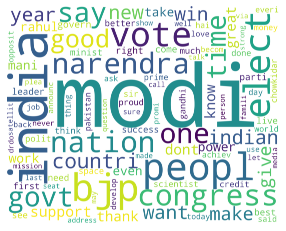

In [ ]:
# for positive
draw_clouds(preprocessed[preprocessed['category']==1]['text'])

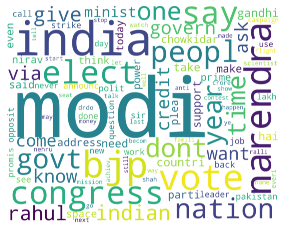

In [ ]:
# for neutral
draw_clouds(preprocessed[preprocessed['category']==0]['text'])

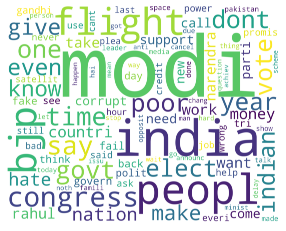

In [ ]:
# for negative
draw_clouds(preprocessed[preprocessed['category']==-1]['text'])

In [ ]:
def draw_frequebcy_bars(series, color):
  freq_dict = defaultdict(int)
  for sample in series:
    for word in word_tokenize(sample):
      freq_dict[word] += 1
  patrial = dict(sorted(freq_dict.items(), key=lambda pair: pair[1], reverse=True)[:20])
  keys = tuple(patrial.keys())
  values = patrial.values()
  fig, ax = plt.subplots( nrows=1, ncols=1)
  fig.set_figwidth(20)
  fig.set_dpi(100)
  ax.barh(keys, values, color=color, edgecolor='black')

Text(0.5, 0, 'Count')

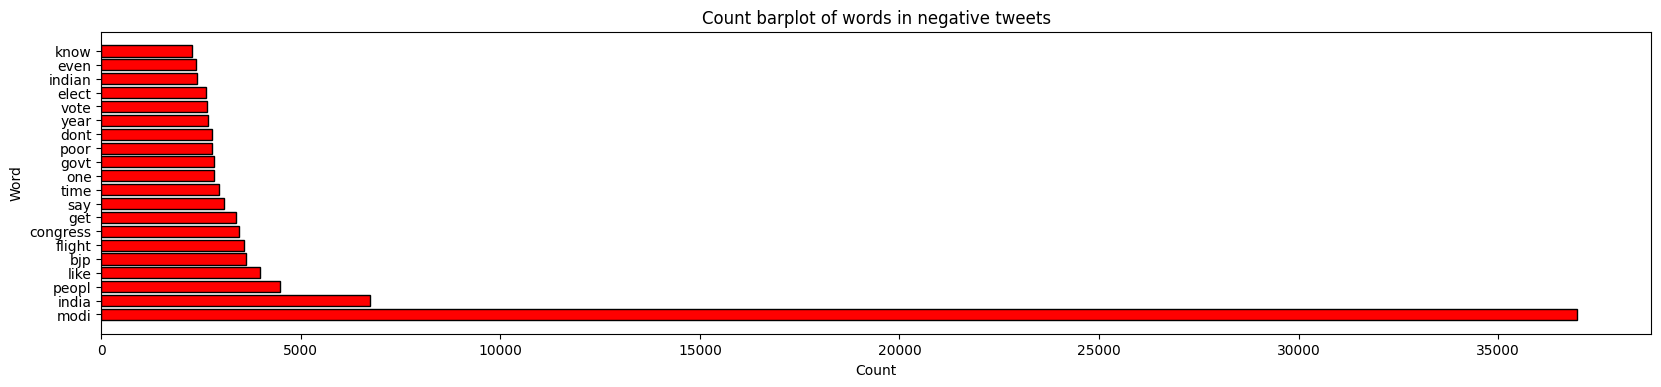

In [ ]:
# negative
draw_frequebcy_bars(preprocessed[preprocessed['category']==-1]['text'], 'red')
plt.title('Count barplot of words in negative tweets')
plt.ylabel('Word')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

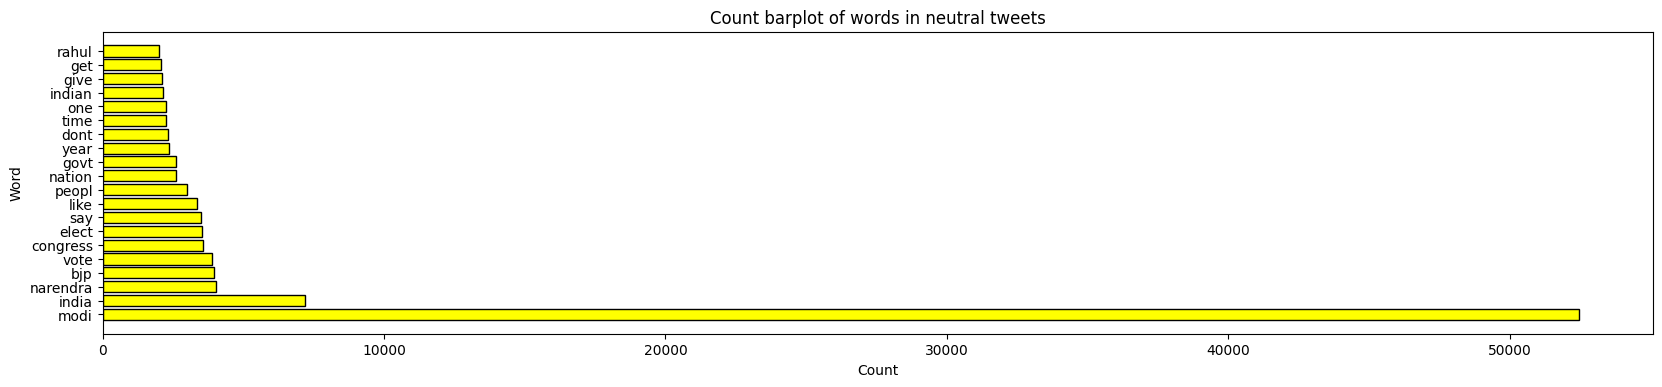

In [ ]:
# neutral
draw_frequebcy_bars(preprocessed[preprocessed['category']==0]['text'], 'yellow')
plt.title('Count barplot of words in neutral tweets')
plt.ylabel('Word')
plt.xlabel('Count')

Text(0.5, 0, 'Count')

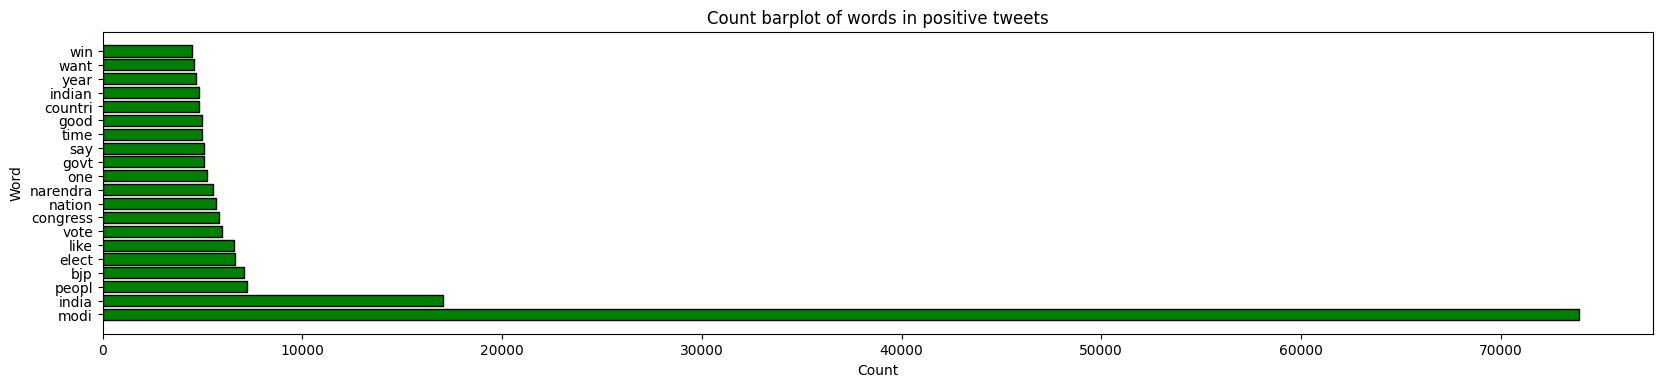

In [ ]:
# positive
draw_frequebcy_bars(preprocessed[preprocessed['category']==1]['text'], 'green')
plt.title('Count barplot of words in positive tweets')
plt.ylabel('Word')
plt.xlabel('Count')

Text(0.5, 1.0, 'Pie chart of percentage of each category')

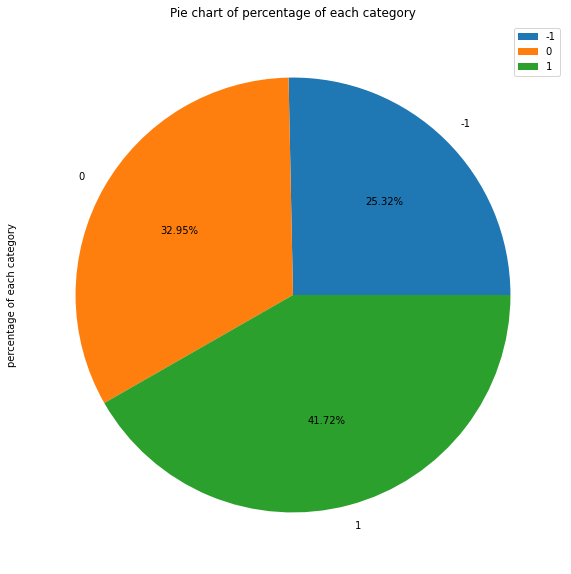

In [ ]:
categories = preprocessed.groupby('category').count()
categories["percentage of each category"] = categories["text"] * 100 / sum(categories["text"])  
categories.plot(kind = "pie",y="percentage of each category",legend=True,figsize=(20,10),autopct="%.2f%%")
plt.title('Pie chart of percentage of each category')
# looks balanced

In [ ]:
tweets_stats = pd.DataFrame()
tweets_stats["text"] = preprocessed["text"].astype(str)
tweets_stats["category"] = preprocessed["category"]
tweets_stats['length'] = tweets_stats["text"].apply(len)
tweets_stats.groupby("category")["length"].describe()


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
-1,45367.0,92.215575,46.176202,3.0,56.0,83.0,130.0,243.0
0,59028.0,60.904622,40.505835,1.0,31.0,51.0,80.0,249.0
1,74747.0,95.854723,47.276879,3.0,57.0,92.0,135.0,244.0


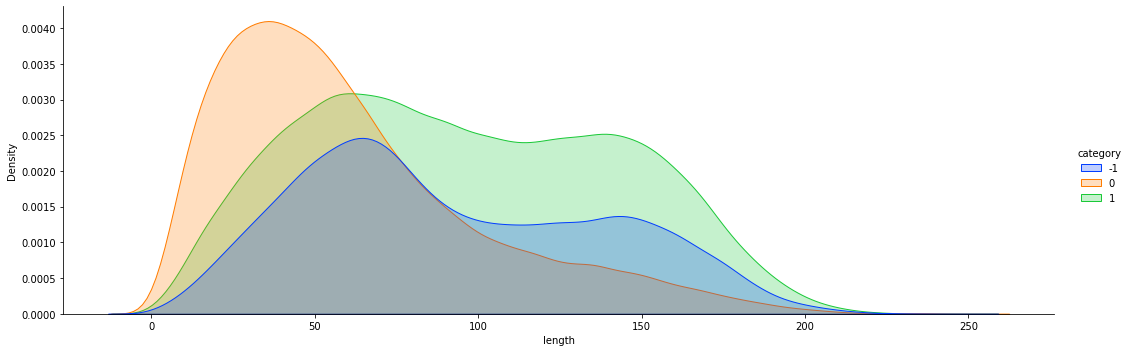

In [ ]:
sns.displot(height = 5, data = tweets_stats, x= "length", hue= "category" , aspect= 3, kind='kde', fill=True, palette=sns.color_palette('bright')[:3])

In [ ]:
freq_dict = defaultdict(int)
for sample in preprocessed[preprocessed['category']==1]['text']:
  for word in word_tokenize(sample):
    freq_dict[word] += 1
positive_words = dict(sorted(freq_dict.items(), key=lambda pair: pair[1], reverse=True))
keys = tuple(positive_words.keys())
values = positive_words.values()

In [ ]:
positive_words

In [ ]:
freq_dict = defaultdict(int)
for sample in preprocessed[preprocessed['category']==-1]['text']:
  for word in word_tokenize(sample):
    freq_dict[word] += 1
negative_words = dict(sorted(freq_dict.items(), key=lambda pair: pair[1], reverse=True))
keys = tuple(negative_words.keys())
values = negative_words.values()

In [ ]:
# the most frequent words that appear in neagtive category, but not in positive
negatives = [distinct for distinct in list(negative_words.keys())[:100] if distinct not in list(positive_words.keys())[:100]]

In [ ]:
# the most frequent words that appear in positive category, but not in negative
positives = [distinct for distinct in list(positive_words.keys())[:100] if distinct not in list(negative_words.keys())[:100]]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def show_n_grams(corpus, n=None, gram=(2,2)):
    vec = CountVectorizer(ngram_range=gram).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key=lambda pair: pair[1], reverse=True)
    bi_dict = defaultdict(int)
    for pair in words_freq[:n]:
      bi_dict[pair[0]] = pair[1]
    fig, ax = plt.subplots( nrows=1, ncols=1)
    fig.set_figwidth(20)
    fig.set_dpi(100)
    ax.barh(tuple(bi_dict.keys()), bi_dict.values())


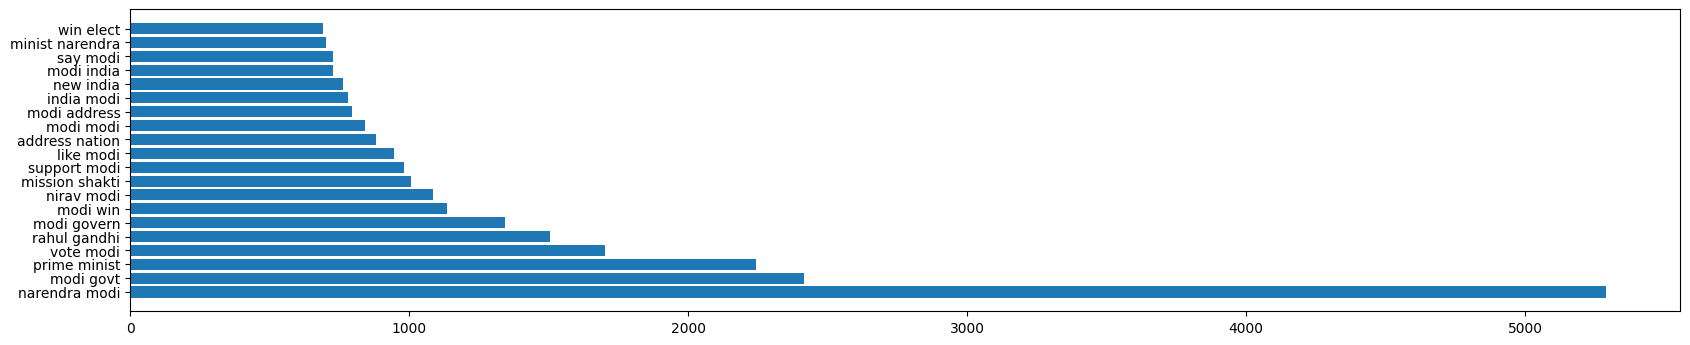

In [ ]:
show_n_grams(preprocessed[preprocessed['category']==1]['text'], 20, (2,2))


# **Cross Validation**

In [ ]:


# def tfidf_accuracy_checker(vec,ngram_range:tuple):
#   result = []
#   for n in [50, 300, 4000]:
#     print(f"{n} iteration")
#     lr = LogisticRegression(max_iter=1000) # max_iter # solver='sag'
#     vec.set_params(max_features=n, ngram_range=ngram_range)
#     tfidf_matrix=vec.fit_transform(preprocessed['text'])
#     X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, preprocessed['category'], test_size=0.2)
#     lr.fit(X_train, y_train)
#     y_pred = lr.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Validation result for {n} features: {accuracy}")
#     result.append((n,accuracy))
#   return result





In [ ]:
# tvec = TfidfVectorizer()
# tfidf_accuracy_checker(tvec, (1,2))

50 iteration
Validation result for 50 features: 0.4849981858271233
300 iteration
Validation result for 300 features: 0.6668620391303134
4000 iteration
Validation result for 4000 features: 0.8210109129476123


[(50, 0.4849981858271233),
 (300, 0.6668620391303134),
 (4000, 0.8210109129476123)]

In [211]:

# make a holdout
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed['text'], preprocessed['category'], test_size=0.2)

## Logistic Regression

In [108]:

def CV_lr():
  pipeline = Pipeline(
      [
          ("tfidf", TfidfVectorizer()),
          ('sp', SelectPercentile(chi2)),
          ("clf", LogisticRegression(solver='sag'))
      ]
  )

  parameters = {
  
      "tfidf__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
      "tfidf__max_features": (1000, 3000, 7000, 10000, 20000, 30000),
      "sp__percentile": ([10,50,100])
      #"lr__solver": ('sag', 'lbfgs')
  }

  grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1) # defaut k=5
  grid_search.fit(X_train, y_train)

  print(f"Best score: {grid_search.best_score_:.4f}")
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))
  return grid_search


In [105]:
def train_and_test(grid_search):
  from sklearn.metrics import plot_confusion_matrix
  # evaluate holdout score
  # pipeline = Pipeline(
  #     [
  #         ("tfidf", TfidfVectorizer(max_features=10000)),
  #         ('skb', SelectPercentile(chi2,percentile=50)),
  #         ("lr", LogisticRegression())
  #     ]
  # )
  pipeline = grid_search.best_estimator_
  pipeline.fit(X_train, y_train)
  pipeline.score(X_test, y_test)
  predictions = pipeline.predict(X_test)

  %time
  from sklearn.metrics import classification_report
  print(classification_report(y_test, predictions))

  plot_confusion_matrix(pipeline, X_test, y_test)
  # print the most relevant words for given params for tfidf and chi2
  tvec = pipeline.get_params()['tfidf']
  # tvec.set_params(max_features=10000, ngram_range=(1,1))
  tfidf_matrix=tvec.fit_transform(preprocessed['text'])


  chi2score, _ = chi2(tfidf_matrix, preprocessed['category'])
  x = sorted(list(zip(chi2score, tvec.get_feature_names_out())), reverse=True)[:20]
  plt.figure(figsize=(15,10))
  plt.barh([xlab[1] for xlab in x],[xlab[0] for xlab in x],align='center', alpha=0.4)
  plt.xlabel('chi^2')


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: 0.8256
Best parameters set:
	sp__percentile: 100
	tfidf__max_features: 10000
	tfidf__ngram_range: (1, 1)
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs
              precision    recall  f1-score   support

          -1       0.81      0.72      0.76      9062
           0       0.80      0.88      0.84     11813
           1       0.86      0.84      0.85     14954

    accuracy                           0.82     35829
   macro avg       0.82      0.82      0.82     35829
weighted avg       0.83      0.82      0.82     35829



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


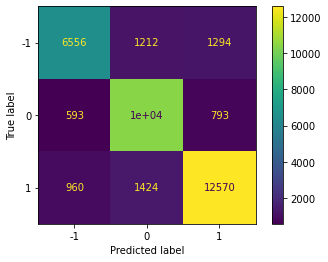

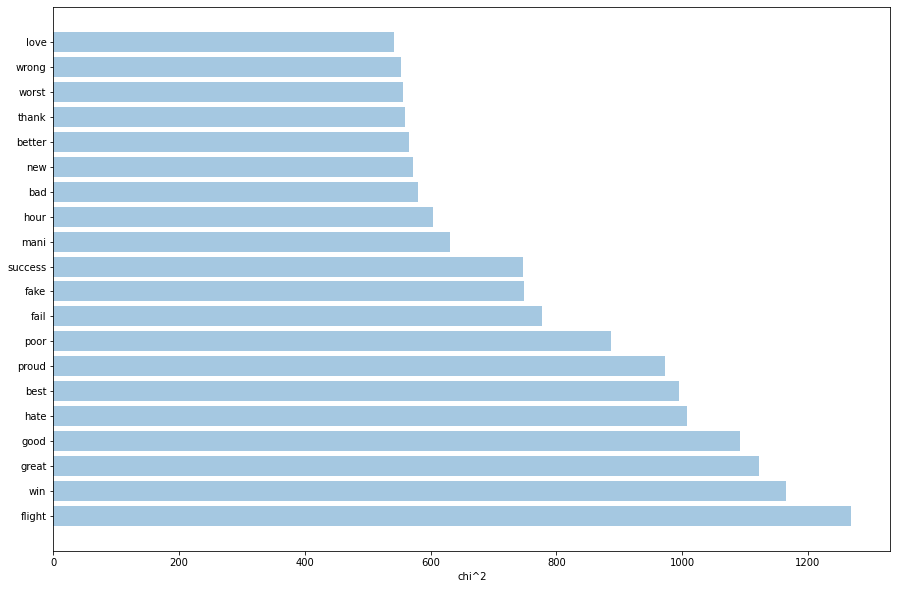

In [109]:
train_and_test(CV_lr())

In [98]:
# insert grid search results into new df
#res_lr = pd.DataFrame(grid_search.cv_results_)

In [ ]:
#sns.lineplot(y=res_lr['mean_test_score'],x=res_lr['param_tfidf__max_features'])

## Naive Bayes

In [223]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# make a holdout
# X_train, X_test, y_train, y_test = train_test_split(
#     preprocessed['text'], preprocessed['category'], test_size=0.2)

def CV_nb():
  pipeline = Pipeline(
      [
          ("tfidf", TfidfVectorizer()),
          ('sp', SelectPercentile(chi2)),
          ("clf", MultinomialNB())
      ]
  )

  parameters = {
  
      #"tfidf__ngram_range": ((1, 1)),  # unigrams or bigrams
      "tfidf__max_features": (1000, 3000, 7000, 10000, 20000, 30000,100000),
      "sp__percentile": ([50,70,100]),
      "clf__alpha": ([0.1, 0.5, 1])
      #"lr__solver": ('sag', 'lbfgs')
  }

  grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1) # defaut k=5

  grid_search.fit(X_train, y_train)

  print(f"Best score: {grid_search.best_score_:.4f}")
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(parameters.keys()):
      print("\t%s: %r" % (param_name, best_parameters[param_name]))
  return grid_search


Fitting 5 folds for each of 63 candidates, totalling 315 fits


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


Best score: 0.6897
Best parameters set:
	clf__alpha: 0
	sp__percentile: 100
	tfidf__max_features: 3000


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs
              precision    recall  f1-score   support

          -1       0.77      0.50      0.61      9062
           0       0.75      0.60      0.67     11813
           1       0.63      0.87      0.73     14954

    accuracy                           0.69     35829
   macro avg       0.72      0.66      0.67     35829
weighted avg       0.71      0.69      0.68     35829



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


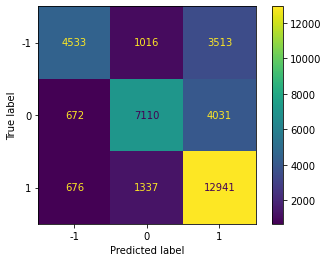

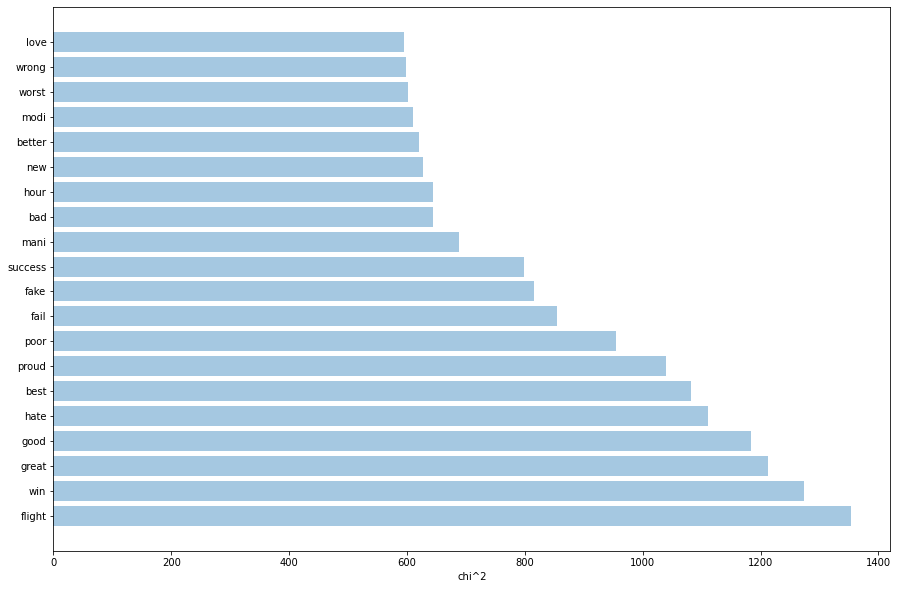

In [107]:
train_and_test(CV_nb())

In [ ]:
# # insert grid search results into new df
# res = pd.DataFrame(grid_search.cv_results_)
# sns.lineplot(y=res['mean_test_score'],x=res['param_tfidf__max_features'])

In [ ]:
lr_pipeline = CV_lr().best_estimator_
nb_pipeline = CV_nb().best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: 0.8244
Best parameters set:
	sp__percentile: 50
	tfidf__max_features: 7000
	tfidf__ngram_range: (1, 1)
Fitting 5 folds for each of 63 candidates, totalling 315 fits


# **Explaining the results**

In [221]:
from lime.lime_text import LimeTextExplainer


def explain_sample(idx):
  explainer = LimeTextExplainer(class_names=[-1,0,1])
  exp = explainer.explain_instance(X_test[idx], lr_pipeline.predict_proba, num_features=15)
  print(f'True class: {y_test[idx]}')
  exp.show_in_notebook(text=True)





In [ ]:
explain_sample(97103)

In [119]:
print('Original prediction:',  lr_pipeline.predict_proba([X_test[144097]]))
tmp = np.array([X_test[144097]])
tmp[0]=tmp[0].replace('modi', '')
print('Prediction after removing some features:', lr_pipeline.predict_proba(tmp))
# print('Difference:', pipeline.get_params()['lr'].predict_proba(tmp)[0, 1] - pipeline.get_params()['lr'].predict_proba(X_test[91767]))

Original prediction: [[0.04944305 0.82443321 0.12612374]]
Prediction after removing some features: [[0.0844822 0.7637389 0.1517789]]


In [220]:
df_oryginal.loc[19345,:]

text        his language speaks regular visitor road also ...
category                                                   -1
Name: 19345, dtype: object

In [214]:
X_test.head(10)

24880     “those elder build home thrown cannot support ...
165404    post disappoint im frequent unit flyer simpl b...
97103                                       alway pari modi
109769           still can match can even come nearest modi
4819      look like time bhajap even go bother jumla pro...
107223    news updat modi slam opposit seek proof balako...
19345     languag speak regular visitor road also show s...
28105     final licens right payrol continu antimodi jib...
41800                                                  wait
53476     modi mention creat system need even know score...
Name: text, dtype: object